#### This notebook shows how to train and evaluate PyTorch models with GluonTS 
While there are no predefined PyTorch estimators yet, you can make use of the convenient evaluation interface of GluonTS to experiment with your own PyTorch forecasting models.

In [1]:
import torch
import torch.nn as nn
import numpy as np

In [2]:
# defining the neural network hyperparameters

prediction_length = 12
context_length = 24

hyperparams = {"prediction_length": prediction_length,
               "context_length": context_length,
               "dims": [96, 48],
               "batch_normalization": True}


In [3]:
# setting up a simple feed forward torch nerual network

class SimpleTorchNetwork(nn.Module):
    
    def __init__(self, prediction_length, context_length, dims, batch_normalization):
        super(SimpleTorchNetwork, self).__init__()
        self.prediction_length = prediction_length
        self.context_length = context_length
        
        modules = []

        for i, units in enumerate(dims):
            if i == 0:
                input_size = context_length
            else:
                input_size = dims[i-1]
            modules += [nn.Linear(input_size, units), nn.ReLU()]
            if batch_normalization:
                modules.append(nn.BatchNorm1d(units))
        
        modules.append(nn.Linear(dims[-1], prediction_length))
        
        self.nn = nn.Sequential(*modules)
        


class SimpleTorchTrainNetwork(SimpleTorchNetwork):
    def forward(self, past_target, future_target):
        prediction = self.nn(past_target)
        # calculate L1 loss with the future_target to learn the median
        return (prediction - future_target).abs().mean(axis=-1)


class SimpleTorchPredNetwork(SimpleTorchTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def forward(self, past_target):
        prediction = self.nn(past_target)
        return prediction.unsqueeze_(1)
    
    
net = SimpleTorchTrainNetwork(**hyperparams)

In [4]:
# defining the input transformation

from gluonts.transform import (
    InstanceSplitter,
    ExpectedNumInstanceSampler
)
from gluonts.dataset.field_names import FieldName

transformation = InstanceSplitter(
                target_field=FieldName.TARGET,
                is_pad_field=FieldName.IS_PAD,
                start_field=FieldName.START,
                forecast_start_field=FieldName.FORECAST_START,
                train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                past_length=context_length,
                future_length=prediction_length)

In [5]:
# creating some artificial time series

from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.artificial import ComplexSeasonalTimeSeries
from gluonts.dataset.common import ListDataset

artificial_dataset = ComplexSeasonalTimeSeries(
    num_series=10,
    prediction_length=prediction_length,
    freq_str="H",
    length_low=50,
    length_high=200,
    min_val=-500,
    max_val=500,
    is_integer=False,
    proportion_missing_values=0,
    is_noise=True,
    is_scale=True,
    percentage_unique_timestamps=1,
    is_out_of_bounds_date=True,
)
train_ds = ListDataset(artificial_dataset.train,
                        freq=artificial_dataset.metadata.freq)
test_ds = ListDataset(artificial_dataset.test,
                        freq=artificial_dataset.metadata.freq)

In [6]:
# defining the training data loader

from gluonts.torch.batchify import batchify 
from gluonts.dataset.loader import TrainDataLoader

batch_size = 32
num_batches_per_epoch = 300

data_loader = TrainDataLoader(train_ds, batch_size=batch_size, stack_fn=batchify,
                              transform=transformation,
                              num_batches_per_epoch=num_batches_per_epoch )

In [7]:
# writing a custom training loop

from tqdm import tqdm
import time

epochs = 40

num_workers = 4
learning_rate = 0.001
weight_decay = 1e-8



optimizer = torch.optim.SGD(
            net.parameters(), lr=learning_rate
        )


for epoch_no in range(epochs):
    
    # mark epoch start time
    tic = time.time()
    avg_epoch_loss = 0.0

    with tqdm(data_loader) as it:
        for batch_no, data_entry in enumerate(it, start=1):

            optimizer.zero_grad()
            inputs = torch.Tensor(data_entry["past_target"])
            targets = torch.Tensor(data_entry["future_target"])
                    
            loss = torch.mean(net(inputs, targets))
            avg_epoch_loss += loss.data.numpy().item()
            it.set_postfix(
                ordered_dict={
                    "avg_epoch_loss": avg_epoch_loss / batch_no,
                    "epoch": epoch_no,
                },
                refresh=False,
            )
            n_iter = epoch_no*num_batches_per_epoch + batch_no
            loss.backward()
            
            optimizer.step()

        # mark epoch end time and log time cost of current epoch
        toc = time.time()


100%|██████████| 300/300 [00:01<00:00, 187.40it/s, avg_epoch_loss=23.4, epoch=39]


In [8]:
# defining the prediction network and copy the parameter from the train network

from gluonts.torch.support.util import copy_parameters
pred_net = SimpleTorchPredNetwork(**hyperparams)
copy_parameters(net, pred_net)



In [9]:
# evaluating the model using a predictor

from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
import json
from gluonts.torch.model.predictor import PyTorchPredictor

predictor = PyTorchPredictor(prediction_length=prediction_length, freq = artificial_dataset.metadata.freq, 
                             input_names = ["past_target"], prediction_net=pred_net, batch_size=32, input_transform=transformation,
                device=None)

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=4000,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)
           
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
print(json.dumps(agg_metrics, indent=4))


Running evaluation: 100%|██████████| 10/10 [00:00<00:00, 201.84it/s]


{
    "MSE": 666.8375935872396,
    "abs_error": 2426.894577026367,
    "abs_target_sum": 10132.549011230469,
    "abs_target_mean": 84.43790842692059,
    "seasonal_error": 19.795207375258308,
    "MASE": 1.2245867107655102,
    "MAPE": 1.1615388343441633,
    "sMAPE": 0.45576968939841944,
    "OWA": NaN,
    "MSIS": 48.98346913373818,
    "QuantileLoss[0.1]": 2047.4313457965852,
    "Coverage[0.1]": 0.4333333333333333,
    "QuantileLoss[0.5]": 2426.894554376602,
    "Coverage[0.5]": 0.4333333333333333,
    "QuantileLoss[0.9]": 2806.3577629566194,
    "Coverage[0.9]": 0.4333333333333333,
    "RMSE": 25.823198748165176,
    "NRMSE": 0.3058247087031374,
    "ND": 0.23951471385300033,
    "wQuantileLoss[0.1]": 0.20206478582312337,
    "wQuantileLoss[0.5]": 0.23951471161765314,
    "wQuantileLoss[0.9]": 0.2769646374121829,
    "mean_absolute_QuantileLoss": 2426.894554376602,
    "mean_wQuantileLoss": 0.23951471161765314,
    "MAE_Coverage": 0.2888888888888889
}


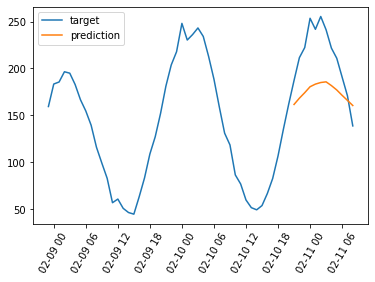

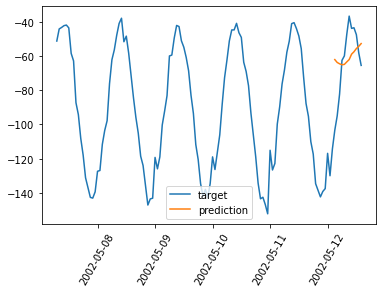

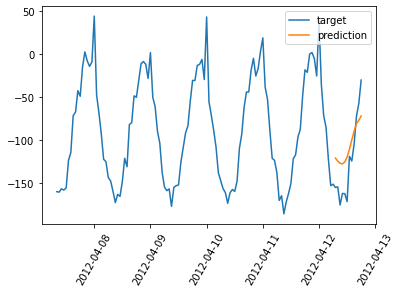

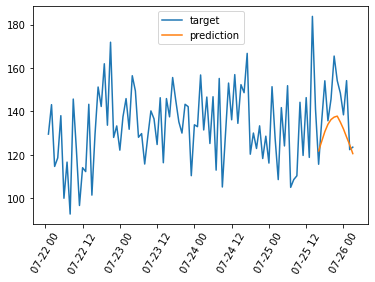

In [10]:
# plotting some forecasts

from matplotlib import pyplot as plt 

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  
    predictor=predictor,
    num_samples=1 # note: in this example we do not do probabilistic forecasting
)

for i, (prediction, target) in enumerate(zip(forecast_it, ts_it)):
    plt.plot(target[len(target)//3:], label="target")
    plt.plot(target.index[-prediction_length:], prediction.samples[0], label="prediction")
    plt.xticks(rotation=60)

    plt.legend()
    plt.show()
    if i ==3:
        break